In [ ]:
from typing import Dict, Tuple

import pandas as pd
from postprocess.lps_plots import sel_evaluation_domain
from products.plot_settings import MF_SYNOPSIS_VAR_NAME, NASA_L3_JPSS1_VAR_NAME, NASA_L3_SNPP_VAR_NAME,MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME
from reductions.statistics_base import EvaluationVsHighResBase
from winter_year import WinterYear
import xarray as xr


wy = WinterYear(2023, 2024)
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_6_lps/analyses/"
)
analysis_type = "confusion_table"

# analyses_dict_confusion = {
#     MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: xr.open_dataset(
#         f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_meteofrance_no_forest_red_band_screen_vs_s2_theia.nc",
#         decode_cf=True,
#     ),
#     NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
#         f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_s2_theia.nc", decode_cf=True
#     ),
#     NASA_L3_JPSS1_VAR_NAME: xr.open_dataset(
#         f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_jpss1_vs_s2_theia.nc",
#         decode_cf=True,
#     ),
# }

# analysis_type = "uncertainty"

# analyses_dict_uncertainty = {
#     MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: xr.open_dataset(
#         f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_meteofrance_no_forest_red_band_screen_vs_s2_theia.nc",
#         decode_cf=True,
#     ),
#     NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
#         f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_s2_theia.nc", decode_cf=True
#     ),
#     NASA_L3_JPSS1_VAR_NAME: xr.open_dataset(
#         f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_jpss1_vs_s2_theia.nc",
#         decode_cf=True,
#     ),
# }


metrics_dict_conf = sel_evaluation_domain(analyses_dict=analyses_dict_confusion)

metrics_dict_unc = sel_evaluation_domain(analyses_dict=analyses_dict_uncertainty)
metrics_dict_unc = {k:v.sum(dim=( 'time')) for k,v in metrics_dict_unc.items()}

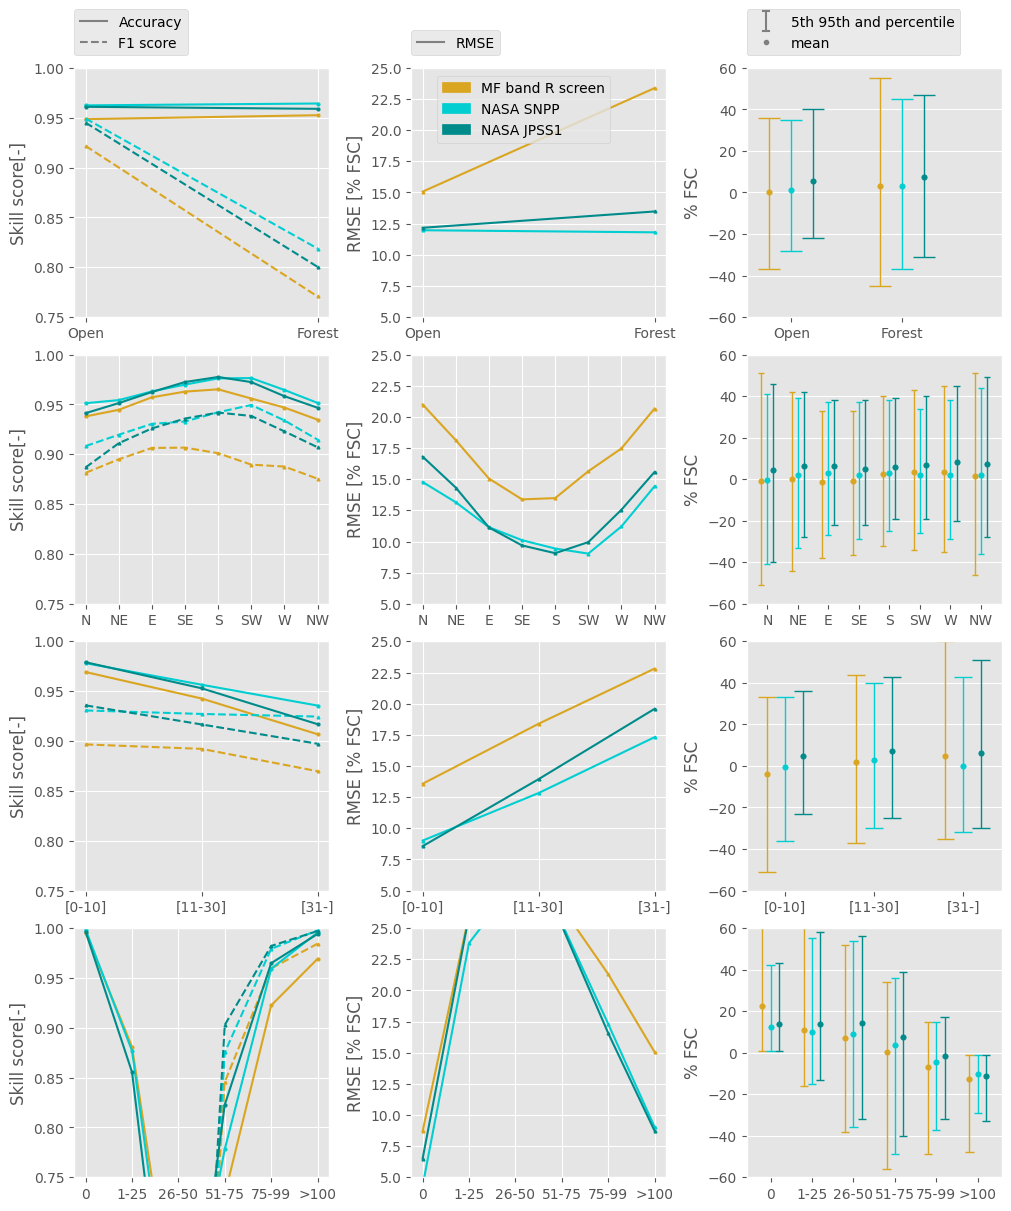

In [27]:
from matplotlib import pyplot as plt
from postprocess.lps_plots import plot_synthesis


params = ['Landcover','Aspect', 'Slope [°]', "Ref FSC [%]"] 
plt.style.use('ggplot')
plot_synthesis(metrics_dict_conf, metrics_dict_unc, params_list=params)


In [44]:
from typing import Dict

import numpy as np

from products.plot_settings import NASA_L3_MULTIPLATFORM_VAR_NAME, PRODUCT_PLOT_COLORS, NASA_L3_JPSS1_VAR_NAME, NASA_L3_SNPP_VAR_NAME
import xarray as xr
from matplotlib import pyplot as plt
from postprocess.error_distribution import histograms_to_biais_rmse

analysis_type = "completeness"
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_6_lps/analyses/"
)
analyses_dict_completeness = {
    # MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: xr.open_dataset(
    #     f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_meteofrance_no_forest_red_band_screen.nc",
    #     decode_cf=True,
    # ),

    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp.nc", decode_cf=True
    ),
    NASA_L3_JPSS1_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_jpss1.nc",
        decode_cf=True,
    ),
    NASA_L3_MULTIPLATFORM_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_multiplatform.nc",
        decode_cf=True,
    ),

}

metrics_dict_completeness = {k:v.sel(time=slice('2023-11', '2024-06')) for k,v in analyses_dict_completeness.items()}

# analysis_type = "uncertainty"

# analyses_dict_uncertainty = {
#     MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: xr.open_dataset(
#         f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_meteofrance_no_forest_red_band_screen_vs_s2_theia.nc",
#         decode_cf=True,
#     ),
#     NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
#         f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_s2_theia.nc", decode_cf=True
#     ),
#     NASA_L3_JPSS1_VAR_NAME: xr.open_dataset(
#         f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_jpss1_vs_s2_theia.nc",
#         decode_cf=True,
#     ),
#     NASA_L3_MULTIPLATFORM_VAR_NAME: xr.open_dataset(
#         f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_multiplatform_vs_s2_theia.nc",
#         decode_cf=True,
#     ),
# }

# # metrics_dict_unc = sel_evaluation_domain(analyses_dict=analyses_dict_uncertainty)
# metrics_dict_unc = {k:v.resample({"time": "1ME"}).sum(dim="time") for k,v in analyses_dict_uncertainty.items()}
# metrics_dict_unc = {k:v.groupby("time").map(histograms_to_biais_rmse) for k,v in metrics_dict_unc.items()}

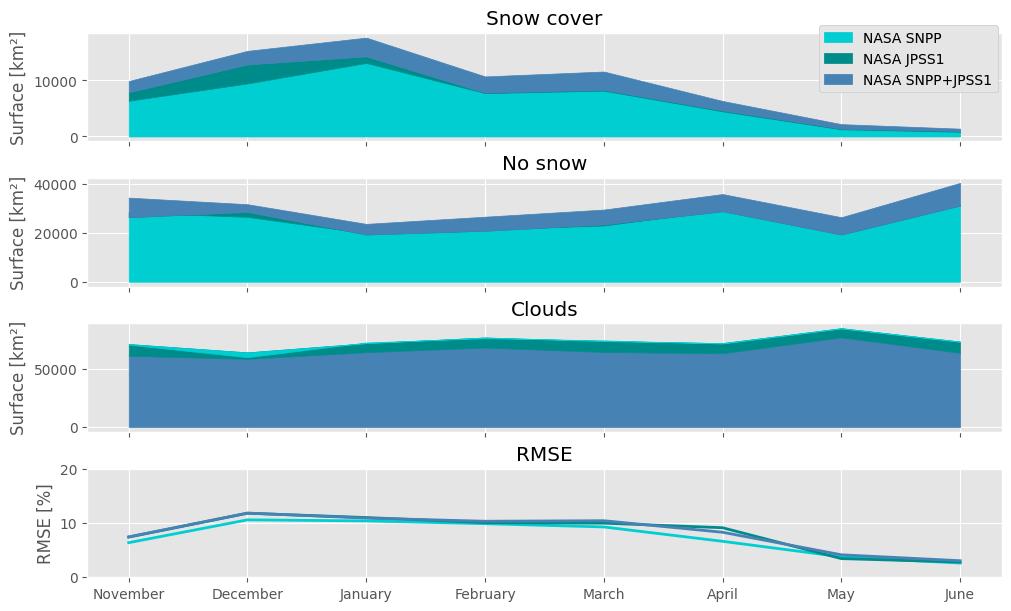

In [71]:

# from postprocess.lps_plots import annual_area_fancy_plot
from products.plot_settings import PRODUCT_PLOT_NAMES

def annual_area_fancy_plot(metrics_dict_completeness: Dict[str, xr.Dataset], metrics_dict_uncertainty: Dict[str, xr.Dataset]):
    if len(metrics_dict_completeness) > 1:
        common_days = np.intersect1d(*[v.coords["time"] for v in metrics_dict_completeness.values()][:2])

    if len(metrics_dict_completeness) > 2:
        for v in metrics_dict_completeness.values():
            common_days = np.intersect1d(common_days, v.coords["time"])

    fig, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True, layout="constrained")
    [ax.set_ylabel("Surface [km²]") for ax in axs[:3]]
    axs[3].set_ylabel("RMSE [%]")
    custom_leg = [
        mpatches.Patch(color=PRODUCT_PLOT_COLORS[product_name], label=PRODUCT_PLOT_NAMES[product_name])
        for product_name in metrics_dict_completeness
    ]
    product_legend = axs[0].legend(handles=custom_leg, loc=[0.8, 0.45])
    axs[0].add_artist(product_legend)
    old_snow_cover, old_no_snow, old_clouds = 0, 0, 0
    for product in metrics_dict_completeness:
        metrics_dict_completeness[product] = metrics_dict_completeness[product].sel(time=common_days)
        product_monthly_averages = (
            metrics_dict_completeness[product].resample({"time": "1ME"}).mean(dim="time").data_vars["surface"] * 1e-6
        )
        # print(product)
        # print(product_monthly_averages.sum(dim="time").to_dataframe())
        # surface_averages.append(product_monthly_averages.sel(class_name="snow_cover").data_vars["surface"] * 1e-6)
        snow_cover = product_monthly_averages.sel(class_name="snow_cover")
        axs[0].fill_between(
            np.arange(product_monthly_averages.sizes["time"]), snow_cover, old_snow_cover, color=PRODUCT_PLOT_COLORS[product]
        )
        old_snow_cover = snow_cover
        no_snow = product_monthly_averages.sel(class_name="no_snow")
        axs[1].fill_between(
            np.arange(product_monthly_averages.sizes["time"]), no_snow, old_no_snow, color=PRODUCT_PLOT_COLORS[product]
        )
        old_no_snow = no_snow

        axs[3].plot(
            np.arange(product_monthly_averages.sizes["time"]),
            metrics_dict_uncertainty[product].rmse,
            color=PRODUCT_PLOT_COLORS[product],
            lw=2,
        )

    # axs[0].set_ylim(0,100)
    # axs[1].set_ylim(0,100)
    # axs[2].set_ylim(0,100)
    axs[3].set_ylim(0, 20)
    for product in [NASA_L3_MULTIPLATFORM_VAR_NAME, NASA_L3_JPSS1_VAR_NAME, NASA_L3_SNPP_VAR_NAME]:
        product_monthly_averages = (
            metrics_dict_completeness[product].resample({"time": "1ME"}).mean(dim="time").data_vars["surface"] * 1e-6
        )
        clouds = product_monthly_averages.sel(class_name="clouds")
        axs[2].fill_between(
            np.arange(product_monthly_averages.sizes["time"]), clouds, old_clouds, color=PRODUCT_PLOT_COLORS[product]
        )
        old_clouds = clouds
    axs[2].set_xticks(np.arange(product_monthly_averages.sizes["time"]))
    axs[2].set_xticklabels(product_monthly_averages.coords["time"].to_dataframe().index.strftime("%B"))
    axs[0].set_title("Snow cover")
    axs[1].set_title("No snow")
    axs[2].set_title("Clouds")
    axs[3].set_title("RMSE")
    plt.show()


annual_area_fancy_plot(metrics_dict_completeness=metrics_dict_completeness,metrics_dict_uncertainty=metrics_dict_unc)

In [99]:

from matplotlib.axes import Axes
import numpy as np

from postprocess.error_distribution import histograms_to_distribution
from products.plot_settings import PRODUCT_PLOT_COLORS


def raw_error_violinplots(metrics_dict: Dict[str, xr.Dataset], analysis_var: str, ax: Axes):
    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    for product_name in metrics_dict:
        error_distributions = []

        for value in metrics_dict[product_name].coords[analysis_var].values:
            prod_selected_metrics = metrics_dict[product_name].sel({analysis_var: value})
            error_distributions.append(histograms_to_distribution(prod_selected_metrics))

        product_boxplot = ax.violinplot(
            error_distributions,
            positions=ticks,
            showextrema=False,
            points=100,
            showmeans=True,
            showmedians=True,
            #quantiles=[[0.1,0.9],[0.1,0.9]]
            # widths=0.2,
            # showfliers=False,
            # patch_artist=True,
            # label=PRODUCT_PLOT_NAMES[product_name],
        )
        for patch in product_boxplot["bodies"]:
            patch.set_facecolor(PRODUCT_PLOT_COLORS[product_name])
        ticks = ticks + 0.2

        print(product_name, value)

    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    ax.set_xticks(ticks + (len(metrics_dict) - 1) * 0.2 / 2)
    ax.grid(True, axis="y")
    ax.legend()

meteofrance_synopsis forest
nasa_l3_snpp forest
nasa_l3_jpss1 forest


/tmp/ipykernel_34532/3346203390.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


meteofrance_synopsis forest
nasa_l3_snpp forest
nasa_l3_jpss1 forest


/tmp/ipykernel_34532/3346203390.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


meteofrance_synopsis forest
nasa_l3_snpp forest
nasa_l3_jpss1 forest


/tmp/ipykernel_34532/3346203390.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


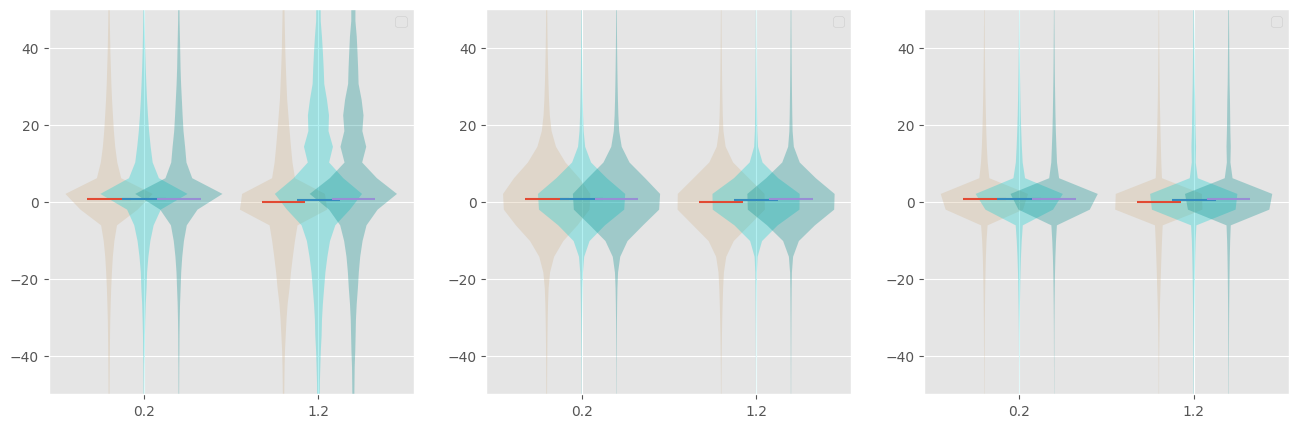

In [ ]:

def raw_error_violinplots(metrics_dict: Dict[str, xr.Dataset], analysis_var: str, ax: Axes, **violinplots_kwargs):
    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    for product_name in metrics_dict:
        error_distributions = []


        prod_selected_metrics = metrics_dict[product_name].groupby((analysis_var, 'time')).map()
        error_distributions.append(histograms_to_distribution(prod_selected_metrics))

        product_boxplot = ax.violinplot(
            error_distributions,
            positions=ticks,
            **violinplots_kwargs
            # showextrema=False,
            # points=100,
            # showmeans=True,
            # showmedians=True,
            # quantiles=[[0.1,0.9],[0.1,0.9]]

            # widths=0.2,
            # showfliers=False,
            # patch_artist=True,
            # label=PRODUCT_PLOT_NAMES[product_name],
        )
        for patch in product_boxplot["bodies"]:
            patch.set_facecolor(PRODUCT_PLOT_COLORS[product_name])
        ticks = ticks + 0.2

        print(product_name, value)

    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    ax.set_xticks(ticks + (len(metrics_dict) - 1) * 0.2 / 2)
    ax.grid(True, axis="y")
    ax.legend()

figs, axs = plt.subplots(1,3, figsize=(16, 5))
[ax.set_ylim(-50,50) for ax in axs]
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[0],showextrema=False,points=50,showmeans=True )
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=50,bw_method=0.5,showmeans=True )
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=50,bw_method=0.1,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=100,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=200,showmeans=True )

In [ ]:

def raw_error_violinplots(metrics_dict: Dict[str, xr.Dataset], analysis_var: str, ax: Axes, **violinplots_kwargs):
    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    for product_name in metrics_dict:
        error_distributions = []

        for value in metrics_dict[product_name].coords[analysis_var].values:
            prod_selected_metrics = metrics_dict[product_name].sel({analysis_var: value})
            error_distributions.append(histograms_to_distribution(prod_selected_metrics))

        product_boxplot = ax.violinplot(
            error_distributions,
            positions=ticks,
            **violinplots_kwargs
            # showextrema=False,
            # points=100,
            # showmeans=True,
            # showmedians=True,
            # quantiles=[[0.1,0.9],[0.1,0.9]]

            # widths=0.2,
            # showfliers=False,
            # patch_artist=True,
            # label=PRODUCT_PLOT_NAMES[product_name],
        )
        for patch in product_boxplot["bodies"]:
            patch.set_facecolor(PRODUCT_PLOT_COLORS[product_name])
        ticks = ticks + 0.2

        print(product_name, value)

    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    ax.set_xticks(ticks + (len(metrics_dict) - 1) * 0.2 / 2)
    ax.grid(True, axis="y")
    ax.legend()

figs, axs = plt.subplots(1,3, figsize=(16, 5))
[ax.set_ylim(-50,50) for ax in axs]
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[0],showextrema=False,points=50,showmeans=True )
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=50,bw_method=0.5,showmeans=True )
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=50,bw_method=0.1,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=100,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=200,showmeans=True )

meteofrance_synopsis


KeyboardInterrupt: 

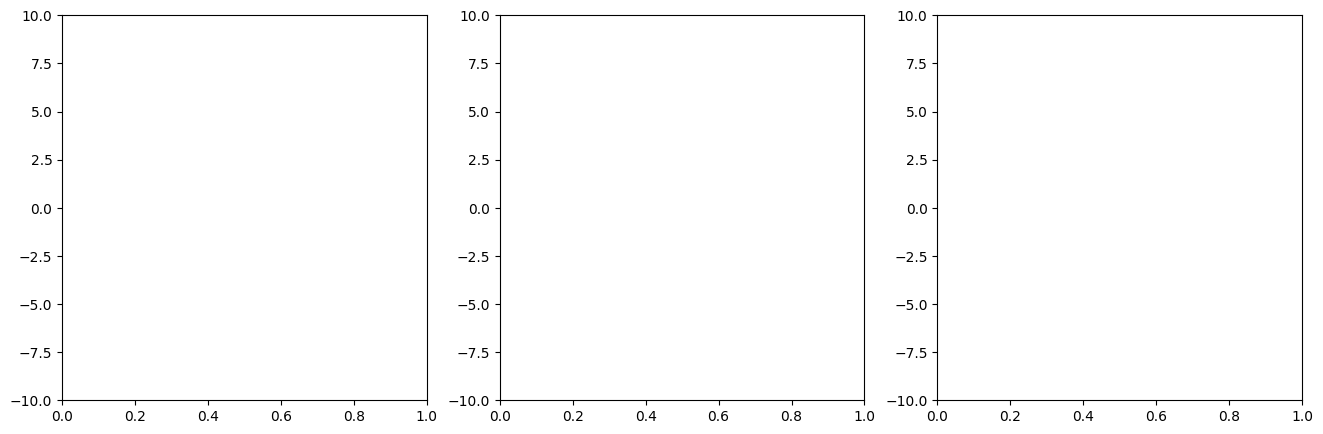

In [ ]:

from postprocess.error_distribution import histograms_to_biais_rmse
from matplotlib.pyplot import Axes
import numpy as np


def raw_error_violinplots(metrics_dict: Dict[str, xr.Dataset], analysis_var: str, ax: Axes, **violinplots_kwargs):
    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    for product_name in metrics_dict:
        print(product_name)
        error_distributions = []

        for value in metrics_dict[product_name].coords[analysis_var].values:
            prod_selected_metrics = metrics_dict[product_name].sel({analysis_var: value})
            error_distributions.append(prod_selected_metrics.groupby('time').map(histograms_to_biais_rmse).data_vars['biais'].values)

        print(error_distributions)
        # print(np.mean(np.array(error_distributions)))
        product_violinplot = ax.violinplot(
            error_distributions,
            positions=ticks,
            **violinplots_kwargs
        )


        product_boxplot = ax.boxplot(
            error_distributions,
            positions=ticks,
            widths=0.2,
            showfliers=False,
            patch_artist=True,
            label=PRODUCT_PLOT_NAMES[product_name],
        )
        for patch in product_violinplot["bodies"]:
            patch.set_facecolor(PRODUCT_PLOT_COLORS[product_name])
        for patch in product_boxplot["boxes"]:
            patch.set_facecolor(color)
        ticks = ticks + 0.2

        # print(product_name, value)

    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    ax.set_xticks(ticks + (len(metrics_dict) - 1) * 0.2 / 2)
    ax.grid(True, axis="y")
    ax.legend()

figs, axs = plt.subplots(1,3, figsize=(16, 5))
[ax.set_ylim(-10,10) for ax in axs]
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[0],showextrema=False,points=100,bw_method='scott',showmeans=True , quantiles=[[0.25, 0.75],[0.25, 0.75]] )
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var='forest_mask_bins', ax=axs[0],showextrema=False,points=200,bw_method='scott',showmeans=True )
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var='forest_mask_bins', ax=axs[1],showextrema=False,points=200,bw_method=0.5,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=100,bw_method='scott',showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=100,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=200,showmeans=True )

/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

meteofrance_synopsis NW


/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

nasa_l3_snpp NW


/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

nasa_l3_jpss1 NW


/tmp/ipykernel_27950/3067715573.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(None,)

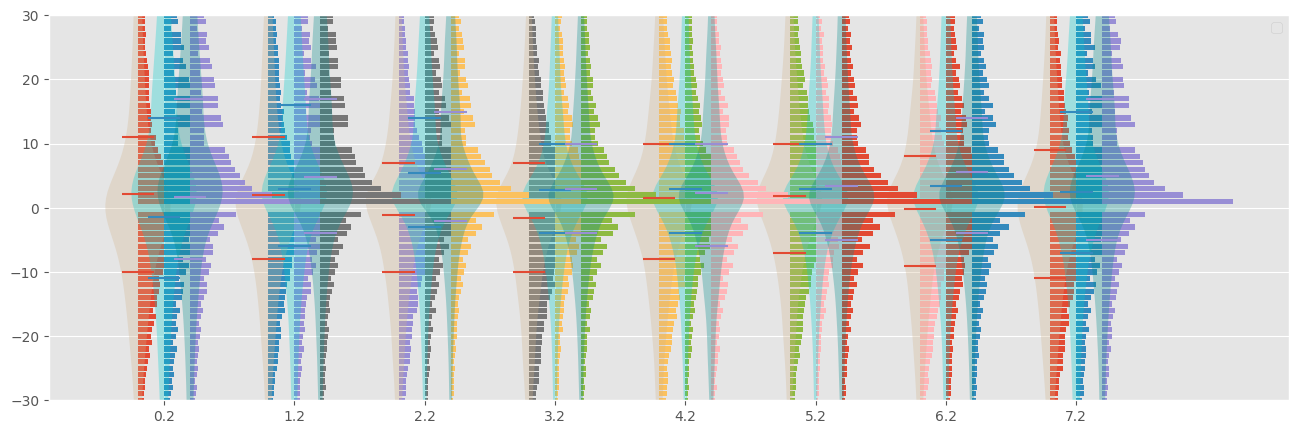

In [143]:
from postprocess.error_distribution import histograms_to_biais_rmse, histograms_to_distribution
from products.plot_settings import PRODUCT_PLOT_COLORS
def raw_error_violinplots(metrics_dict: Dict[str, xr.Dataset], analysis_var: str, ax: Axes, **violinplots_kwargs):
    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    for product_name in metrics_dict:
        error_distributions = []

        for i,value in enumerate(metrics_dict[product_name].coords[analysis_var].values):
            prod_selected_metrics = metrics_dict[product_name].sel({analysis_var: value}).drop_sel(biais_bins=[0])
            error_distributions.append(histograms_to_distribution(prod_selected_metrics))
            red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
            ax.barh(red.biais_bins,width=red.n_occurrences/red.n_occurrences.max(),left=ticks[i])

        product_boxplot = ax.violinplot(
            error_distributions,
            positions=ticks,
            **violinplots_kwargs,
            # showextrema=False,
            # points=100,
            # showmeans=True,
            # showmedians=True,
            quantiles=[[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75]]

            # widths=0.2,
            # showfliers=False,
            # patch_artist=True,
            # label=PRODUCT_PLOT_NAMES[product_name],
        )


        for patch in product_boxplot["bodies"]:
            patch.set_facecolor(PRODUCT_PLOT_COLORS[product_name])
        ticks = ticks + 0.2

        print(product_name, value)

    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    ax.set_xticks(ticks + (len(metrics_dict) - 1) * 0.2 / 2)
    ax.grid(True, axis="y")
    ax.legend()

figs, axs = plt.subplots(1,1, figsize=(16, 5))
# figs.style.use('ggplot')
# [axs[0].set_ylim(-50,50) for ax in axs]
axs.set_ylim(-30,30)
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var='aspect_bins', ax=axs,showextrema=False,points=200,showmeans=True),#quantiles=[[0.1,0.9],[0.1,0.9],[0.1,0.9],[0.1,0.9],[0.1,0.9]])
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=200,bw_method=0.5,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=200,bw_method=0.1,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=100,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=200,showmeans=True )

In [106]:
metrics_dict_unc['meteofrance_synopsis'].sel(forest_mask_bins='no_forest').drop([0],dim='biais_bins')

/tmp/ipykernel_27950/3639521670.py:1: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
  metrics_dict_unc['meteofrance_synopsis'].sel(forest_mask_bins='no_forest').drop([0],dim='biais_bins')


<xarray.Dataset> Size: 20MB
Dimensions:             (biais_bins: 200, ref_bins: 13, sensor_zenith_bins: 6,
                         slope_bins: 4, altitude_bins: 5, aspect_bins: 8)
Coordinates:
  * biais_bins          (biais_bins) int64 2kB -100 -99 -98 -97 ... 97 98 99 100
  * ref_bins            (ref_bins) int64 104B 0 10 20 30 40 ... 80 90 99 100 255
  * sensor_zenith_bins  (sensor_zenith_bins) int64 48B 15 30 45 60 75 255
    forest_mask_bins    <U9 36B 'no_forest'
  * slope_bins          (slope_bins) int64 32B 10 30 50 90
  * altitude_bins       (altitude_bins) int64 40B 900 1500 2100 2700 3300
  * aspect_bins         (aspect_bins) object 64B 'N' 'NE' 'E' ... 'SW' 'W' 'NW'
Data variables:
    n_occurrences       (biais_bins, ref_bins, sensor_zenith_bins, slope_bins, aspect_bins, altitude_bins) float64 20MB ...

In [48]:
reduced = metrics_dict_unc['meteofrance_synopsis'].sel(forest_mask_bins='no_forest').sum(dim=metrics_dict_unc['meteofrance_synopsis'].dims.pop('biais_bins'))
plt.barh(reduced.n_occurrences, reduced.biais_bins)

AttributeError: 'FrozenMappingWarningOnValuesAccess' object has no attribute 'pop'

In [43]:
np.linspace(smooth[0], smooth[-1], len(smooth[100:]))

array([98.4 , 98.11, 97.82, 97.53, 97.24, 96.95, 96.66, 96.37, 96.08,
       95.79, 95.5 , 95.21, 94.92, 94.63, 94.34, 94.05, 93.76, 93.47,
       93.18, 92.89, 92.6 , 92.31, 92.02, 91.73, 91.44, 91.15, 90.86,
       90.57, 90.28, 89.99, 89.7 , 89.41, 89.12, 88.83, 88.54, 88.25,
       87.96, 87.67, 87.38, 87.09, 86.8 , 86.51, 86.22, 85.93, 85.64,
       85.35, 85.06, 84.77, 84.48, 84.19, 83.9 , 83.61, 83.32, 83.03,
       82.74, 82.45, 82.16, 81.87, 81.58, 81.29, 81.  , 80.71, 80.42,
       80.13, 79.84, 79.55, 79.26, 78.97, 78.68, 78.39, 78.1 , 77.81,
       77.52, 77.23, 76.94, 76.65, 76.36, 76.07, 75.78, 75.49, 75.2 ,
       74.91, 74.62, 74.33, 74.04, 73.75, 73.46, 73.17, 72.88, 72.59,
       72.3 , 72.01, 71.72, 71.43, 71.14, 70.85, 70.56, 70.27, 69.98,
       69.69, 69.4 ])

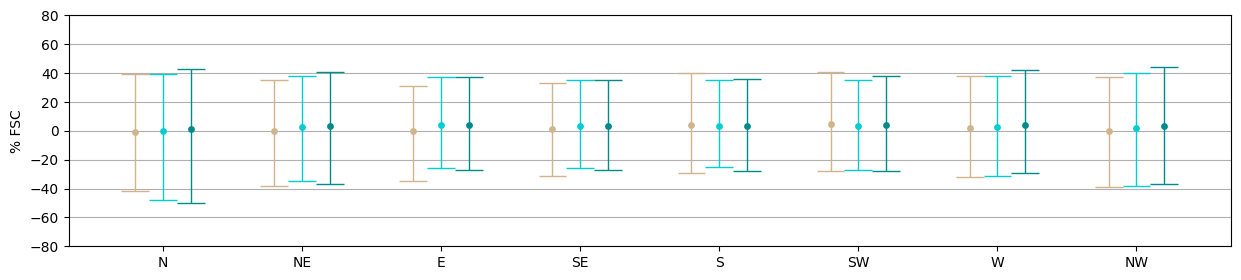

In [ ]:
from typing import Any
import numpy as np
from postprocess.error_distribution import histograms_to_biais_rmse, histograms_to_distribution
from products.plot_settings import PRODUCT_PLOT_COLORS
import matplotlib.patches as mpatches

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")
# red = metrics_dict_unc['meteofrance_synopsis'].sel(aspect_bins='S')





def plot_custom_spans(metrics_dict: Dict[str, xr.Dataset],analysis_var: str,  ax :plt.Axes):
    
    x_positions = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    x_positions = x_positions/len(x_positions)
    ax.set_ylim(-60,60)
    for product_name, metrics_dataset in metrics_dict.items():
        
        color = PRODUCT_PLOT_COLORS[product_name]
        analysis_coords = metrics_dict[product_name].coords[analysis_var].values
        box_width_data = 0.2/len(x_positions)
        for idx, value in enumerate(analysis_coords):
            x_pos = x_positions[idx]
            product_analysis_var_dataset=  metrics_dataset.sel({analysis_var: value}).drop_sel(biais_bins=0)
            reduced =product_analysis_var_dataset.groupby('biais_bins').sum(list(product_analysis_var_dataset.sizes.keys()))
            smooth = smooth_data_np_convolve(reduced.data_vars['n_occurrences'], 1)
            smooth = smooth/smooth.max() 

            biais_rmse = histograms_to_biais_rmse(reduced)
            distr = histograms_to_distribution(reduced)
            ax.scatter(x_pos, biais_rmse.data_vars['biais'], marker='o', color=color, s=15,zorder=3)

            whiskers_min=np.quantile(distr,0.05)
            whiskers_max=np.quantile(distr,0.95)
            ax.vlines(x_pos, whiskers_min, whiskers_max, color=color, linestyle='-', lw=1, label=product_name)

            ax.hlines(whiskers_min, x_pos-box_width_data/2, x_pos+box_width_data/2, color=color, lw=1)
            ax.hlines(whiskers_max, x_pos-box_width_data/2,x_pos+box_width_data/2, color=color, lw=1)
        x_positions = x_positions+box_width_data
    
    ax.set_xticks(x_positions - box_width_data*((len(metrics_dict)+1)//2), labels=analysis_coords)
    ax.set_ylabel(f"% FSC")
    # custom_leg = [mpatches.Patch(color=PRODUCT_PLOT_COLORS[product_name], label=PRODUCT_PLOT_NAMES[product_name]) for product_name in metrics_dict]
    # ax.legend(handles=custom_leg)

fig, ax = plt.subplots(figsize=(15,3))


metrics_dict_unc_new = {k: v.sel(ref_bins=slice(None, 101)) for k,v in metrics_dict_unc.items()}
ax.grid(axis='y')
plot_custom_spans(metrics_dict=metrics_dict_unc_new, analysis_var='aspect_bins',ax=ax)





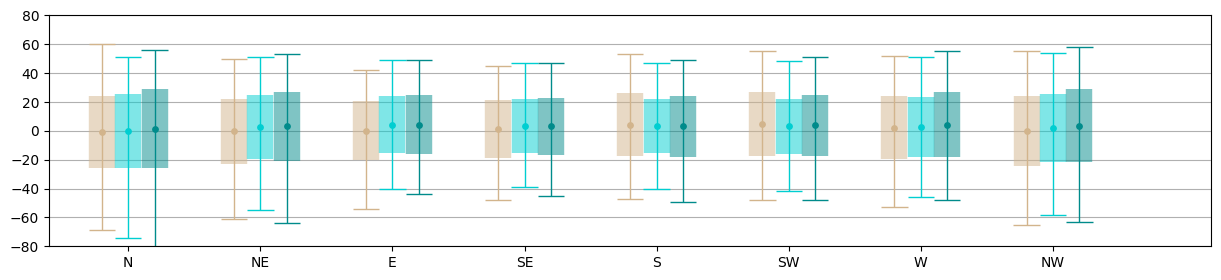

In [ ]:
from typing import Any
import numpy as np
from postprocess.error_distribution import histograms_to_biais_rmse, histograms_to_distribution
from products.plot_settings import PRODUCT_PLOT_COLORS
def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")
# red = metrics_dict_unc['meteofrance_synopsis'].sel(aspect_bins='S')

def linewidth_from_data_units(linewidth, axis, reference='y'):
    """
    Convert a linewidth in data units to linewidth in points.

    Parameters
    ----------
    linewidth: float
        Linewidth in data units of the respective reference-axis
    axis: matplotlib axis
        The axis which is used to extract the relevant transformation
        data (data limits and size must not change afterwards)
    reference: string
        The axis that is taken as a reference for the data width.
        Possible values: 'x' and 'y'. Defaults to 'y'.

    Returns
    -------
    linewidth: float
        Linewidth in points
    """
    fig = axis.get_figure()
    if reference == 'x':
        length = fig.bbox_inches.width * axis.get_position().width
        value_range = np.diff(axis.get_xlim())
    elif reference == 'y':
        length = fig.bbox_inches.height * axis.get_position().height
        value_range = np.diff(axis.get_ylim())
    # Convert length to points
    length *= 72
    # Scale linewidth to value range
    return linewidth * (length / value_range)




def plot_custom_violin(metrics_dict: Dict[str, xr.Dataset],analysis_var: str,  ax :plt.Axes):
    
    x_positions = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    x_positions = x_positions/len(x_positions)
    ax.set_ylim(-80,80)
    ax.set_xlim(-0.05,1.05)
    for product_name, metrics_dataset in metrics_dict.items():
        
        color = PRODUCT_PLOT_COLORS[product_name]
        analysis_coords = metrics_dict[product_name].coords[analysis_var].values
        box_width_data = 0.2/len(x_positions)
        fig = ax.get_figure()
        w = fig.bbox_inches.width* ax.get_position().width
        value_range = np.diff(ax.get_xlim())
        box_width_points = box_width_data * (72*w/value_range)
        # print(linewidth_from_data_units(box_width_data,ax,'y'))
        for idx, value in enumerate(analysis_coords):
            x_pos = x_positions[idx]
            product_analysis_var_dataset=  metrics_dataset.sel({analysis_var: value}).drop_sel(biais_bins=0)
            reduced =product_analysis_var_dataset.groupby('biais_bins').sum(list(product_analysis_var_dataset.sizes.keys()))
            smooth = smooth_data_np_convolve(reduced.data_vars['n_occurrences'], 1)
            smooth = smooth/smooth.max() 


            biais_rmse = histograms_to_biais_rmse(reduced)
            distr = histograms_to_distribution(reduced)
            ax.scatter(x_pos, biais_rmse.data_vars['biais'], marker='o', color=color, s=15,zorder=3)

            whiskers_min=np.quantile(distr,0.02)
            whiskers_max=np.quantile(distr,0.98)
            ax.vlines(x_pos, whiskers_min, whiskers_max, color=color, linestyle='-', lw=1)
            ax.vlines(x_pos, biais_rmse.biais-biais_rmse.rmse, biais_rmse.biais+biais_rmse.rmse, color=color, linestyle='-', lw=box_width_points,alpha=0.5)

            ax.hlines(whiskers_min, x_pos-box_width_data/2, x_pos+box_width_data/2, color=color, lw=1)
            ax.hlines(whiskers_max, x_pos-box_width_data/2,x_pos+box_width_data/2, color=color, lw=1)
        x_positions = x_positions+box_width_data
    
    ax.set_xticks(x_positions - box_width_data*((len(metrics_dict)+1)//2), labels=analysis_coords)
    # ax.set_xticklabels()


fig, ax = plt.subplots(figsize=(15,3))


metrics_dict_unc_new = {k: v.sel(ref_bins=slice(None, 101)) for k,v in metrics_dict_unc.items()}
ax.grid(axis='y')
plot_custom_violin(metrics_dict=metrics_dict_unc_new, analysis_var='aspect_bins',ax=ax)

# ticks = []
# selection = metrics_dict_unc['meteofrance_synopsis'].sel(ref_bins=slice(None, 101))
# for i, b in enumerate(selection.ref_bins):
#     plot_custom_violin(ds = selection.sel(ref_bins=b), ax=ax,x_pos=i*3)
#     ticks.append(i*3)
# ax.set_xticks(ticks)
# ax.set_xticklabels(selection.ref_bins.values)



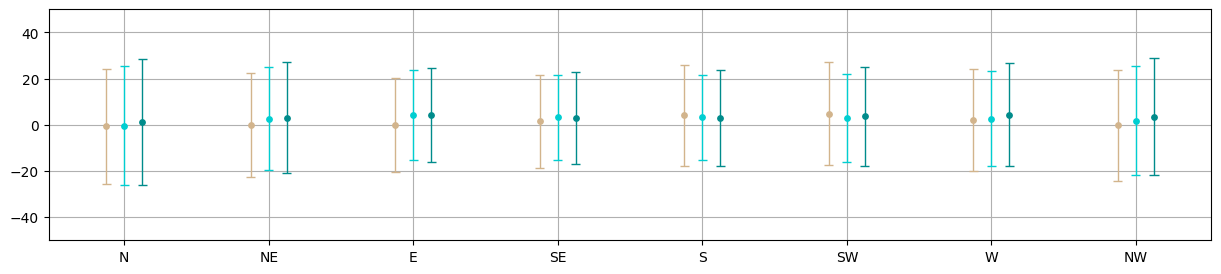

In [6]:
from typing import Any
import numpy as np
from postprocess.error_distribution import histograms_to_biais_rmse, histograms_to_distribution
from products.plot_settings import PRODUCT_PLOT_COLORS
def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")
# red = metrics_dict_unc['meteofrance_synopsis'].sel(aspect_bins='S')

def plot_custom_violin(metrics_dict: Dict[str, xr.Dataset],analysis_var: str,  ax :plt.Axes):
    x_positions = np.arange(8*len(list(metrics_dict.values())[0].coords[analysis_var].values),step=8)
    for product_name, metrics_dataset in metrics_dict.items():
        
        color = PRODUCT_PLOT_COLORS[product_name]
        analysis_coords = metrics_dict[product_name].coords[analysis_var].values
        for idx, value in enumerate(analysis_coords):
            x_pos = x_positions[idx]
            product_analysis_var_dataset=  metrics_dataset.sel({analysis_var: value}).drop_sel(biais_bins=0)
            reduced =product_analysis_var_dataset.groupby('biais_bins').sum(list(product_analysis_var_dataset.sizes.keys()))
            smooth = smooth_data_np_convolve(reduced.data_vars['n_occurrences'], 1)
            smooth = smooth/smooth.max() 

            # ax.fill_betweenx(reduced.coords['biais_bins'],x_pos,x_pos+smooth,color=color, alpha=0.25)
            # ax.plot(x_pos+smooth, reduced.coords['biais_bins'],color=color,lw=0.5)
            # ax.fill_betweenx( reduced.coords['biais_bins'],x_pos, x_pos-smooth,color=color, alpha=0.25)
            # ax.plot(x_pos-smooth, reduced.coords['biais_bins'],color=color,lw=0.5)

            biais_rmse = histograms_to_biais_rmse(reduced)
            distr = histograms_to_distribution(reduced)
            # ax.vlines(x_pos, np.quantile(distr,0.05), np.quantile(distr,0.95), color=color, linestyle='-',alpha=0.5, lw=5)
            ax.scatter(x_pos, biais_rmse.data_vars['biais'], marker='o', color=color, s=15,zorder=3)

            # whiskers_min=reduced.where(reduced.data_vars['n_occurrences']>0,drop=True).coords['biais_bins'].min()
            # whiskers_max=reduced.where(reduced.data_vars['n_occurrences']>0,drop=True).coords['biais_bins'].max()
            whiskers_min=biais_rmse.biais - biais_rmse.rmse
            whiskers_max=biais_rmse.biais + biais_rmse.rmse
            ax.vlines(x_pos, whiskers_min, whiskers_max, color=color, linestyle='-', lw=1)
            ax.hlines(whiskers_min, x_pos-0.25, x_pos+0.25, color=color, lw=1)
            ax.hlines(whiskers_max, x_pos-0.25,x_pos+ 0.25, color=color, lw=1)
        x_positions = x_positions+1
    ax.set_ylim(-50,50)
    ax.set_xticks(x_positions - 1*((len(metrics_dict)+1)//2))
    ax.set_xticklabels(analysis_coords)


fig, ax = plt.subplots(figsize=(15,3))


metrics_dict_unc_new = {k: v.sel(ref_bins=slice(None, 101)) for k,v in metrics_dict_unc.items()}
plot_custom_violin(metrics_dict=metrics_dict_unc_new, analysis_var='aspect_bins',ax=ax)
ax.grid('y')
# ticks = []
# selection = metrics_dict_unc['meteofrance_synopsis'].sel(ref_bins=slice(None, 101))
# for i, b in enumerate(selection.ref_bins):
#     plot_custom_violin(ds = selection.sel(ref_bins=b), ax=ax,x_pos=i*3)
#     ticks.append(i*3)
# ax.set_xticks(ticks)
# ax.set_xticklabels(selection.ref_bins.values)



In [290]:
metrics_dict_unc

{'meteofrance_synopsis': <xarray.Dataset> Size: 40MB
 Dimensions:             (biais_bins: 201, ref_bins: 13, sensor_zenith_bins: 6,
                          forest_mask_bins: 2, slope_bins: 4, altitude_bins: 5,
                          aspect_bins: 8)
 Coordinates:
   * biais_bins          (biais_bins) int64 2kB -100 -99 -98 -97 ... 97 98 99 100
   * ref_bins            (ref_bins) int64 104B 0 10 20 30 40 ... 80 90 99 100 255
   * sensor_zenith_bins  (sensor_zenith_bins) int64 48B 15 30 45 60 75 255
   * forest_mask_bins    (forest_mask_bins) <U9 72B 'no_forest' 'forest'
   * slope_bins          (slope_bins) int64 32B 10 30 50 90
   * altitude_bins       (altitude_bins) int64 40B 900 1500 2100 2700 3300
   * aspect_bins         (aspect_bins) object 64B 'N' 'NE' 'E' ... 'SW' 'W' 'NW'
 Data variables:
     n_occurrences       (biais_bins, ref_bins, sensor_zenith_bins, forest_mask_bins, slope_bins, aspect_bins, altitude_bins) float64 40MB ...,
 'nasa_l3_snpp': <xarray.Dataset> Size: 7M